In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
load_dotenv()

True

In [ ]:
llm = ChatOpenAI (model='gpt-4o-mini')
parser = StrOutputParser()

In [ ]:
prompt = PromptTemplate(
    input_variables=["sr", "bpb", "boundary_parcentage"],
    template="Based on the stats: Strike Rate: {sr}, Balls Per Boundary: {bpb}, and Boundary Percentage: {boundary_parcentage}, briefly describe the player's performance. Additionally, guess a name of a player who might match this performance.",
)

In [ ]:
# define state
class cricket_state(TypedDict):
    run:int
    balls:int
    sixes:int
    foures:int
    
    sr:float
    bpb:float
    boundary_parcentage:float
    summery:str

In [ ]:
def calculate_sr(state: cricket_state) -> cricket_state:
    run = state["run"]
    balls = state["balls"]

    sr = run / balls * 100

    state["sr"] = sr

    return {"sr": sr}

In [ ]:
def calculate_bpb(state: cricket_state) -> cricket_state:
    balls = state["balls"]
    sixes = state["sixes"]
    foures = state["foures"]

    bpb = (sixes + foures ) / balls

    state["bpb"] = bpb

    return {"bpb": bpb}

In [ ]:
def calculate_boundary_percentage(state: cricket_state) -> cricket_state:
    sixes = state["sixes"]
    foures = state["foures"]
    run = state["run"]

    boundary_parcentage = (sixes * 6 + foures * 4) / run * 100

    state["boundary_parcentage"] = boundary_parcentage

    return {"boundary_parcentage": boundary_parcentage}

In [ ]:
def generate_summery(state: cricket_state) -> cricket_state:
    chain = prompt | llm | parser

    summery = chain.invoke(
        {
            "sr": state["sr"],
            "bpb": state["bpb"],
            "boundary_parcentage": state["boundary_parcentage"],
        }
    )
    state["summery"] = summery

    return {"summery": summery}

In [ ]:
# Define the graph
graph = StateGraph(cricket_state)

In [ ]:
# add nodes
graph.add_node("calculate_sr", calculate_sr)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("calculate_boundary_percentage", calculate_boundary_percentage)
graph.add_node("generate_summery", generate_summery)

In [ ]:
# add edges
graph.add_edge(START, "calculate_sr")
graph.add_edge(START, "calculate_bpb")
graph.add_edge(START, "calculate_boundary_percentage")

#
graph.add_edge("calculate_sr", "generate_summery")
graph.add_edge("calculate_bpb", "generate_summery")
graph.add_edge("calculate_boundary_percentage", "generate_summery")
#
graph.add_edge("generate_summery", END)

In [ ]:
# compile the graph
work_flow = graph.compile()

In [ ]:
# execute the graph

initial_state = {"run": 149, "balls": 44, "sixes": 16, "foures": 9}

final_state = work_flow.invoke(initial_state)

In [ ]:
# print state
print(final_state)

{'run': 149, 'balls': 44, 'sixes': 16, 'foures': 9, 'sr': 338.6363636363636, 'bpb': 0.5681818181818182, 'boundary_parcentage': 88.59060402684564, 'summery': "The player's performance statistics indicate an extremely aggressive batting style. A strike rate of 338.64 suggests that they score runs very quickly, indicating a high level of aggression and ability to find boundaries. The stat of 0.57 balls per boundary implies that the player is hitting a boundary (either four or six) roughly every half a ball, which is exceptional and highlights their ability to consistently find the boundary. Additionally, a boundary percentage of 88.59% indicates that a significant majority of their runs are coming from boundaries, further emphasizing their explosive batting approach.\n\nGiven these performance metrics, a player who might match this style of performance could be someone like Chris Gayle, who is known for his explosive batting and ability to score heavily in limited-overs formats. Other mod

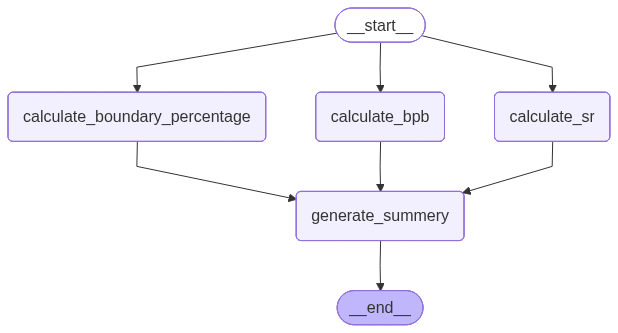

In [ ]:
# View Graph
from IPython.display import Image

Image(work_flow.get_graph().draw_mermaid_png())